# Section 3: Homework Exercises

This material provides some hands-on experience using the methods learned from the third day's material.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as st
import pymc as pm
import arviz as az

## Exercise: Titanic survival model

Load the titanic dataset, and construct an appropriate model to predict passenger survival rate. Summarize the parameter estimates.

In [3]:
DATA_URL = 'https://raw.githubusercontent.com/fonnesbeck/bayes_course_2022/master/data/'

try:
    titanic = pd.read_excel('../data/titanic.xls')
except FileNotFoundError:
    titanic = pd.read_excel(DATA_URL + 'titanic.xls')
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


/Users/cfonnesbeck/mambaforge/envs/bayes_course/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in age_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s_age, m_age, age_imputed_unobserved, beta_pclass, beta, beta_age, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

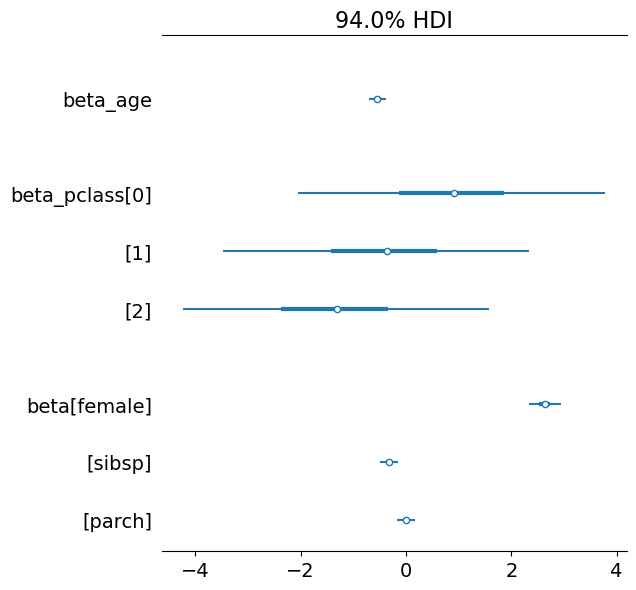

In [4]:
# Write your answer here

data_subset = titanic.assign(female=(titanic.sex=='female').astype(int))[['pclass', 'female', 'age', 'sibsp', 'parch']]
y = titanic.survived.values

data_subset.isnull().mean()

age_mean, age_std = data_subset.age.mean(), data_subset.age.std()

age = data_subset.pop('age').values
age = (age - age_mean) / age_std

pclass = data_subset.pop('pclass').values - 1
pclass

X = data_subset.values

with pm.Model(coords=dict(coefficients=data_subset.columns.values)) as titanic_model:

    s_age = pm.HalfNormal('s_age', 3)
    m_age = pm.Normal('m_age', 0, 3)
    age_imputed = pm.Normal('age_imputed', m_age, s_age, observed=age)

    beta_pclass = pm.Normal('beta_pclass', 0, 3, size=3)

    beta = pm.Normal('beta', 0, 3, dims='coefficients')
    beta_age = pm.Normal('beta_age', 0, 3)
    mu = pm.Normal('mu', 0, 3)

    p = pm.math.invlogit(mu + beta_age*age_imputed + beta_pclass[pclass] + pm.math.dot(X, beta))

    survival = pm.Bernoulli('survival', p=p, observed=y)

    trace = pm.sample()

az.plot_forest(trace, var_names=['beta_age', 'beta_pclass', 'beta'], combined=True)